In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:
val_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),#ランダムに反転
    transforms.ColorJitter(),#ランダムに色調を変化させる
    transforms.RandomRotation(10),#ランダムに回転(角度)
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_dataset=datasets.CIFAR10(root="./data",train=True,download=True,transform=train_transform)
validation_dataset=datasets.CIFAR10(root="./data",train=False,download=True,transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
names=("plane","car","bird","cat","deer","dog","flog","horse","ship","truck")

In [ ]:
train_dataloader=DataLoader(train_dataset,batch_size=32,shuffle=True)
validation_dataloader=DataLoader(validation_dataset,batch_size=32,shuffle=False)

In [ ]:
data_iter=iter(train_dataloader)

In [ ]:
imgs,labels=next(data_iter)

In [ ]:
labels

tensor([0, 5, 6, 3, 5, 4, 7, 0, 6, 7, 5, 8, 3, 5, 1, 1, 4, 2, 6, 5, 2, 4, 1, 0,
        3, 2, 9, 9, 0, 5, 4, 0])

In [ ]:
imgs.size()#[バッチ数,チャネル,h,w]

torch.Size([32, 3, 32, 32])

In [ ]:
img=imgs[0]

In [ ]:
img_permute=img.permute(1,2,0)

In [ ]:
img_permute=0.5*img_permute+0.5#明るさ調整

In [ ]:
img_permute=np.clip(img_permute,0,1)

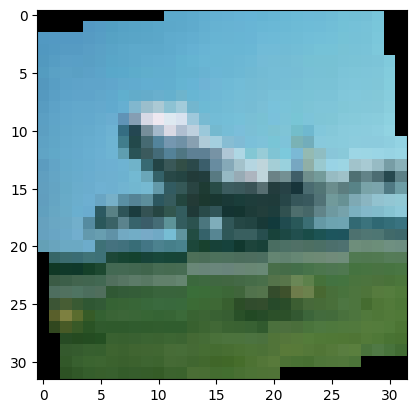

In [ ]:
plt.imshow(img_permute)

In [ ]:
class CNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.features=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=5,padding=2),#畳み込み層、特徴算出
            nn.ReLU(inplace=True),#活性化関数
            nn.MaxPool2d(kernel_size=2),#プーリング層(Max)、サイズを小さくする
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),#畳み込み層、特徴算出
            nn.ReLU(inplace=True),#活性化関数
            nn.MaxPool2d(kernel_size=2),#プーリング層(Max)、サイズを小さくする
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),#畳み込み層、特徴算出
            nn.ReLU(inplace=True),#活性化関数
            nn.MaxPool2d(kernel_size=2),#プーリング層(Max)、サイズを小さくする
            nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,padding=1),#畳み込み層、特徴算出
            nn.ReLU(inplace=True),#活性化関数
        )
        self.classifier=nn.Linear(in_features=4*4*128,out_features=num_classes)#全結合層
    def forward(self,x):
        x=self.features(x)
        x=x.view(x.size(0),-1)#1次元のベクトル化
        x=self.classifier(x)
        return x


In [ ]:
model=CNN(10)
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001,weight_decay=5e-4)#weight_decay:重みづけが大きくなりすぎないようにするオプション

In [ ]:
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc.cpu())
    #
    # validation loop
    #
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc.cpu())
    print("epoch: {}, loss: {}, acc: {},val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.4295806628499974, acc: 0.4785068929195404,val loss: 1.1960841906718171, val acc: 0.587260365486145
epoch: 1, loss: 1.0135994916227637, acc: 0.641234815120697,val loss: 0.8655660134344436, val acc: 0.7014776468276978
epoch: 2, loss: 0.8648570912317519, acc: 0.6970969438552856,val loss: 0.7896977916312294, val acc: 0.7223442196846008
epoch: 3, loss: 0.7850095326425323, acc: 0.7257077693939209,val loss: 0.7134679972458953, val acc: 0.7518969774246216
epoch: 4, loss: 0.7242686401287562, acc: 0.7465611100196838,val loss: 0.7158923404761397, val acc: 0.7601836919784546
epoch: 5, loss: 0.6921563027420642, acc: 0.7589371204376221,val loss: 0.6904564461769006, val acc: 0.7601836919784546
epoch: 6, loss: 0.6602117354795098, acc: 0.7715930938720703,val loss: 0.6738657632384437, val acc: 0.7650758624076843
epoch: 7, loss: 0.6387956349115987, acc: 0.7793306112289429,val loss: 0.6573627769185332, val acc: 0.7766573429107666
epoch: 8, loss: 0.6131408385508196, acc: 0.788387715816497

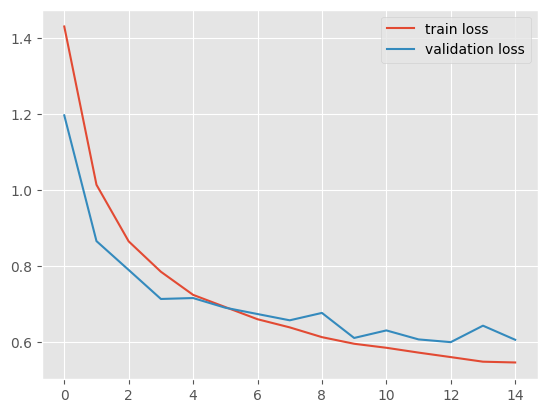

In [ ]:
plt.style.use("ggplot")
plt.plot(losses,label="train loss")
plt.plot(val_losses,label="validation loss")
plt.legend()

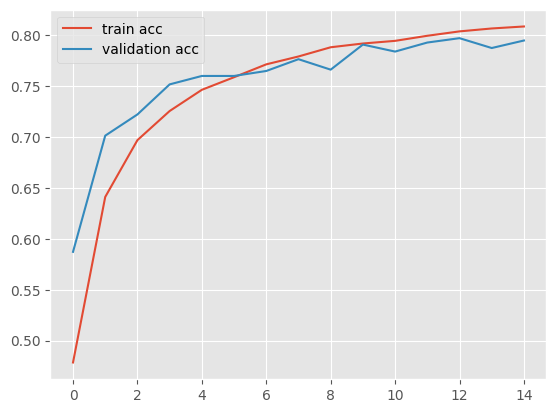

In [ ]:
plt.plot([accs_.cpu() for accs_ in accs],label="train acc")
plt.plot([val_accs_.cpu() for val_accs_ in val_accs],label="validation acc")
plt.legend()